# https://www.kaggle.com/c/mercari-price-suggestion-challenge 

Цель работы - построить и испытать ансамбли моделей для задачи онлайн-магазина Mercari. Алгоритм должнен быть способен предлагать разумные цены на товары для продавцов, основываясь на категории товара, брэнде, состоянии и текстовом описании.

In [33]:
import time
import re
from __future__ import print_function
from collections import defaultdict

import pandas as pd
import pandas_profiling
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_union, make_pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder, MinMaxScaler,  Imputer, LabelBinarizer, OneHotEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import Ridge, RidgeCV, ARDRegression, BayesianRidge, HuberRegressor, LassoCV, SGDRegressor, TheilSenRegressor
from sklearn.metrics import accuracy_score, mean_squared_log_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

import xgboost as xgb
import lightgbm as lgb

import gc

%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 8)
pd.options.display.float_format = '{:.2f}'.format

In [34]:
df = pd.read_csv('mercari/train.tsv', sep='\t')

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
train_id             1482535 non-null int64
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1476208 non-null object
brand_name           849853 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482531 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


Разведывательный анализ данных на подвыборке.

In [36]:
df_sample = pd.read_csv('mercari/train.tsv', nrows=1067, sep='\t')

In [37]:
df_sample.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.00,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.00,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.00,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.00,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.00,0,Complete with certificate of authenticity


In [38]:
df_test = pd.read_csv('mercari/test_stg2.tsv', sep='\t')

In [39]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3460725 entries, 0 to 3460724
Data columns (total 7 columns):
test_id              int64
name                 object
item_condition_id    int64
category_name        object
brand_name           object
shipping             int64
item_description     object
dtypes: int64(3), object(4)
memory usage: 184.8+ MB


In [40]:
df_test.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


Зависимоть цены от других признаков.

In [41]:
pandas_profiling.ProfileReport(df_sample)

Number of variables,8
Number of observations,1067
Total Missing (%),5.2%
Total size in memory,66.8 KiB
Average record size in memory,64.1 B
Numeric,3
Categorical,4
Boolean,1
Date,0
Text (Unique),0
Rejected,0


Предварительный анализ показывает, что распределение цены на товар характеризуется длинным правым хвостом. Для дальнейшего исследования возьмем логарифм значения цены. Также наблюдается очень слабая отрицательная зависимость цены с признаком "shipping".

In [42]:
df_sample["price_log"] = np.log(df_sample["price"]+1)
y_sample = df_sample["price_log"]

Среднее значение цены в зависимости от признака "shipping". Цена обычно выше в тех случаях, когда покупатель платит за доставку.

In [43]:
df_sample.groupby("shipping").mean()["price_log"]

shipping
0   3.14
1   2.77
Name: price_log, dtype: float64

Среднее цены по состоянию товара. Явных зависимостей не прослеживается.

In [44]:
df_sample.groupby("item_condition_id").mean()["price_log"]

item_condition_id
1   2.98
2   2.98
3   2.96
4   2.86
5   3.12
Name: price_log, dtype: float64

Распределение значений цены в группах по состоянию товара. Видно уменьшение вариативности цены при ухудшении качества. Попробуем далее оценить этот признак по его вкладу в ошибку модели.

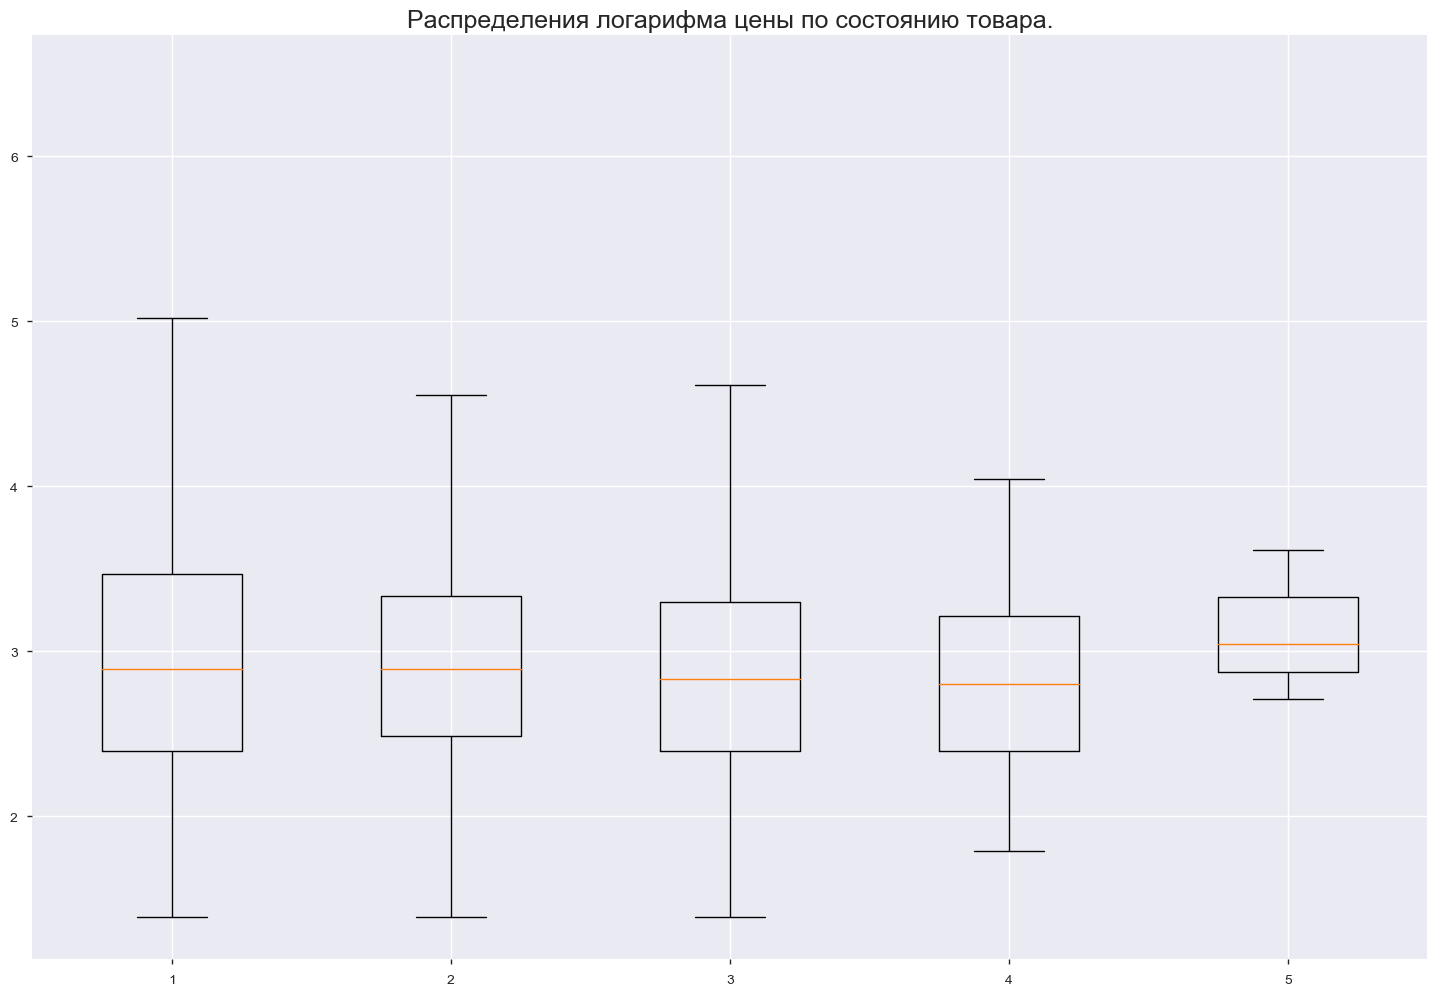

In [45]:
ai_df = df_sample[["item_condition_id", "price_log"]].copy()

fig, ax = plt.subplots(1, 1, figsize=(18, 12))

ax.boxplot([ai_df[ai_df["item_condition_id"]==i]["price_log"] for i in range(1,6)])
ax.set_title("Распределения логарифма цены по состоянию товара.", fontsize=18)

plt.show()

Среднее значение цены по брэнду. Видна некоторая связь этих признаков. Используем эту информацию для кодировки переменной "brand_name". Это создает новый признак "brand_name_le", имеющий корреляцию с логарифмом цены 0,66.

In [46]:
def process_brand(data):
    data["brand_name"].fillna("NaN", inplace=True)
    bn_pl = data.groupby("brand_name").mean()["price_log"].sort_values()
    data['brand_name_le'] = data['brand_name'].map(bn_pl.to_dict())
    return

In [47]:
process_brand(df_sample)

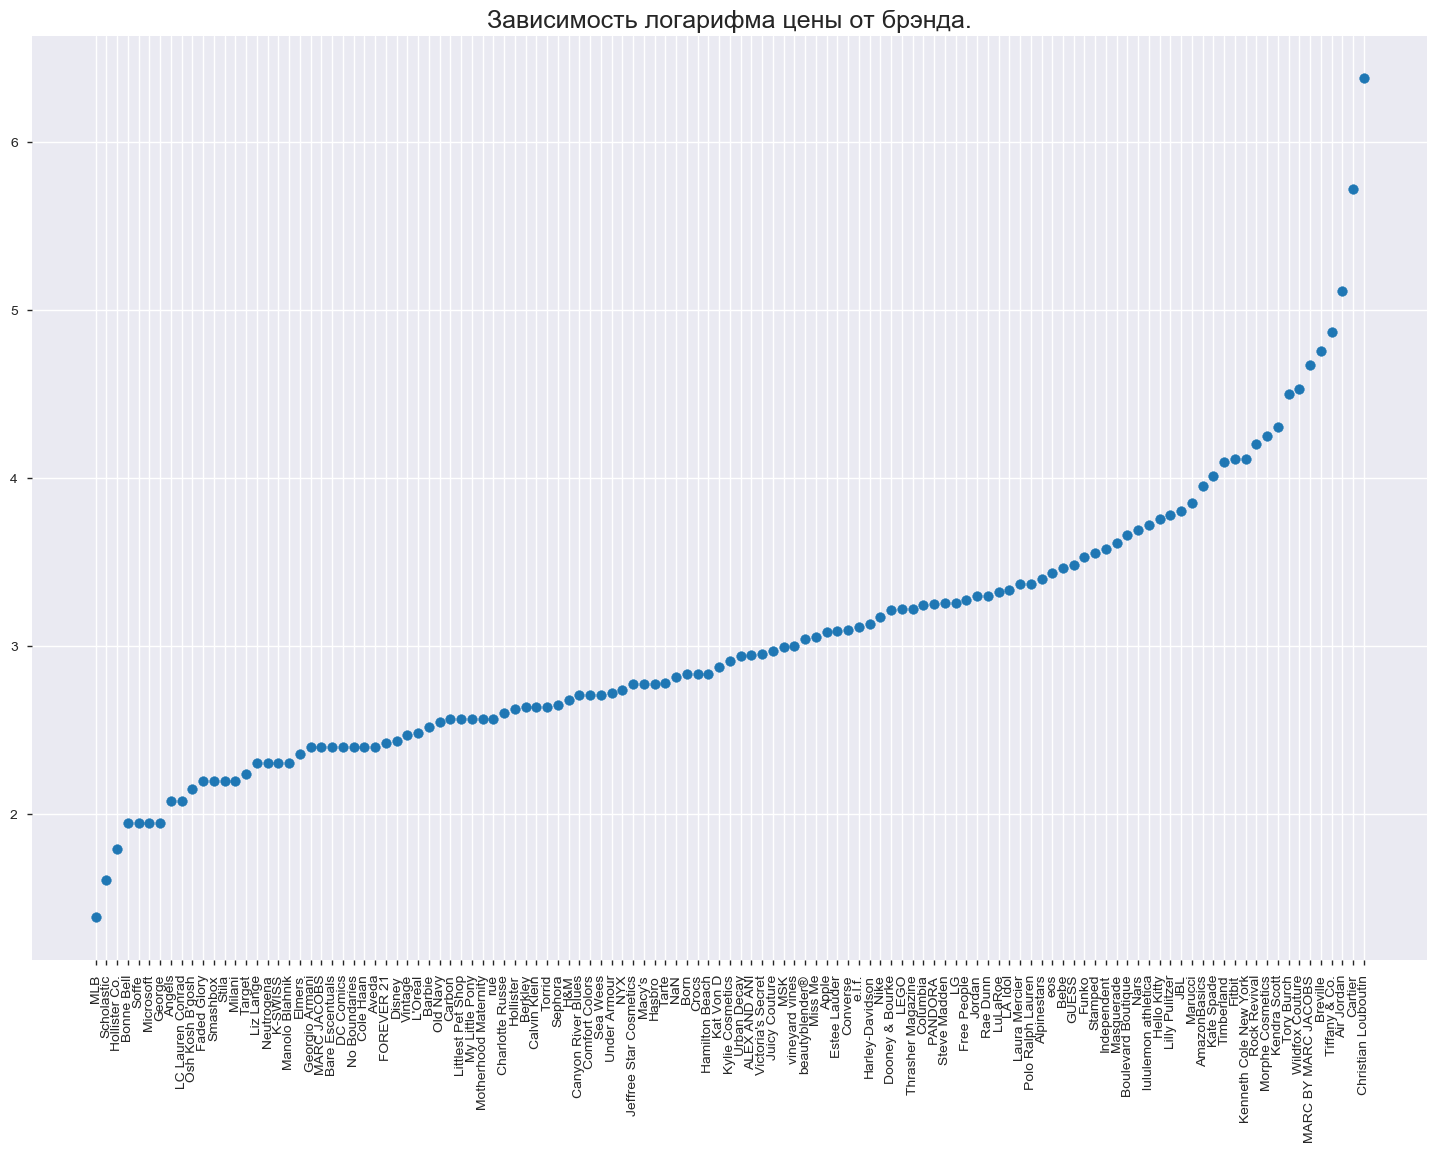

In [48]:
bn_pl = df_sample.groupby("brand_name").mean()["price_log"].sort_values()

fig, ax = plt.subplots(1, 1, figsize=(18, 12))

ax.scatter(bn_pl.index[1::2], bn_pl.values[1::2])
ax.set_title("Зависимость логарифма цены от брэнда.", fontsize=18)
ax.set_xticklabels(bn_pl.index[1::2], rotation=90)

plt.show()

In [49]:
df_sample.corr()

,train_id,item_condition_id,price,shipping,price_log,brand_name_le
train_id,1.00,0.02,-0.04,0.03,-0.02,0.03
item_condition_id,0.02,1.00,-0.01,-0.18,-0.02,0.05
price,-0.04,-0.01,1.00,-0.09,0.74,0.58
shipping,0.03,-0.18,-0.09,1.00,-0.24,-0.18
price_log,-0.02,-0.02,0.74,-0.24,1.00,0.66
brand_name_le,0.03,0.05,0.58,-0.18,0.66,1.00


В качестве baseline использовалась регрессионная модель (ridge), построенная на признаках "shipping", "brand_name_le", "item_condition_id". Последний признак был оставлен, поскольку повысил значение $R^2$ почти на 3%. Ее результат в kaggle составил 0,64267.

In [50]:
df["price_log"] = np.log(df["price"]+1)
process_brand(df)
df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,price_log,brand_name_le
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.00,1,No description yet,2.40,2.80
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.00,0,This keyboard is in great condition and works ...,3.97,3.69
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.00,1,Adorable top with a hint of lace and a key hol...,2.40,2.64
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.00,1,New with tags. Leather horses. Retail for [rm]...,3.58,2.80
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.00,0,Complete with certificate of authenticity,3.81,2.80


In [51]:
y = df["price_log"].values
X = df[["item_condition_id", "shipping", "brand_name_le"]].values
X_ic = df[["shipping", "brand_name_le"]].values

In [52]:
reg_ic = RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0, 1000.0], cv=5)
reg = RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0, 1000.0], cv=5)
reg_ic.fit(X_ic, y)
reg.fit(X, y)

print("R^2 регрессии с учетом item_condition_id: {0}, \nR^2 без этого признака: {1}".format(reg.score(X, y),
                                                                                            reg_ic.score(X_ic, y)))
RMSLE_ic = np.sqrt(mean_squared_log_error(y_true=np.exp(y), y_pred=np.exp(reg_ic.predict(X_ic))))
RMSLE = np.sqrt(mean_squared_log_error(y_true=np.exp(y), y_pred=np.exp(reg.predict(X))))
print("RMSLE регрессии с учетом item_condition_id: {0}, \nRMSLE без этого признака: {1}".format(RMSLE, RMSLE_ic))

R^2 регрессии с учетом item_condition_id: 0.27419972054841957, 
R^2 без этого признака: 0.2666387727738383
RMSLE регрессии с учетом item_condition_id: 0.6062873409859204, 
RMSLE без этого признака: 0.6095400466339993


Добавление признаков. Разделение категорий на подкатегории с дальнейшим кодированием средним значением цены в каждой из подгрупп. Зависимости представлены на графиках ниже.

In [53]:
def process_category(data):
    data["category_name"].fillna("NaN/NaN/NaN", inplace=True)
    
    data["category_0"] = data["category_name"].str.extract("([^/]+)/[^/]+/[^/]+")
    data["category_1"] = data["category_name"].str.extract("[^/]+/([^/]+)/[^/]+")
    data["category_2"] = data["category_name"].str.extract("[^/]+/[^/]+/([^/]+)")
    
    cat0_pl = data.groupby("category_0").mean()["price_log"].sort_values()
    cat1_pl = data.groupby("category_1").mean()["price_log"].sort_values()
    cat2_pl = data.groupby("category_2").mean()["price_log"].sort_values()
    
    data['category_0_le'] = data['category_0'].map(cat0_pl.to_dict())
    data['category_1_le'] = data['category_1'].map(cat1_pl.to_dict())
    data['category_2_le'] = data['category_2'].map(cat2_pl.to_dict())

In [54]:
process_category(df_sample)
df_sample.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,price_log,brand_name_le,category_0,category_1,category_2,category_0_le,category_1_le,category_2_le
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.00,1,No description yet,2.40,2.82,Men,Tops,T-shirts,3.17,2.75,2.64
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.00,0,This keyboard is in great condition and works ...,3.97,3.97,Electronics,Computers & Tablets,Components & Parts,2.99,3.58,3.97
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.00,1,Adorable top with a hint of lace and a key hol...,2.40,2.24,Women,Tops & Blouses,Blouse,3.10,2.67,2.68
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.00,1,New with tags. Leather horses. Retail for [rm]...,3.58,2.82,Home,Home Décor,Home Décor Accents,2.97,2.71,2.46
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.00,0,Complete with certificate of authenticity,3.81,2.82,Women,Jewelry,Necklaces,3.10,3.14,2.92


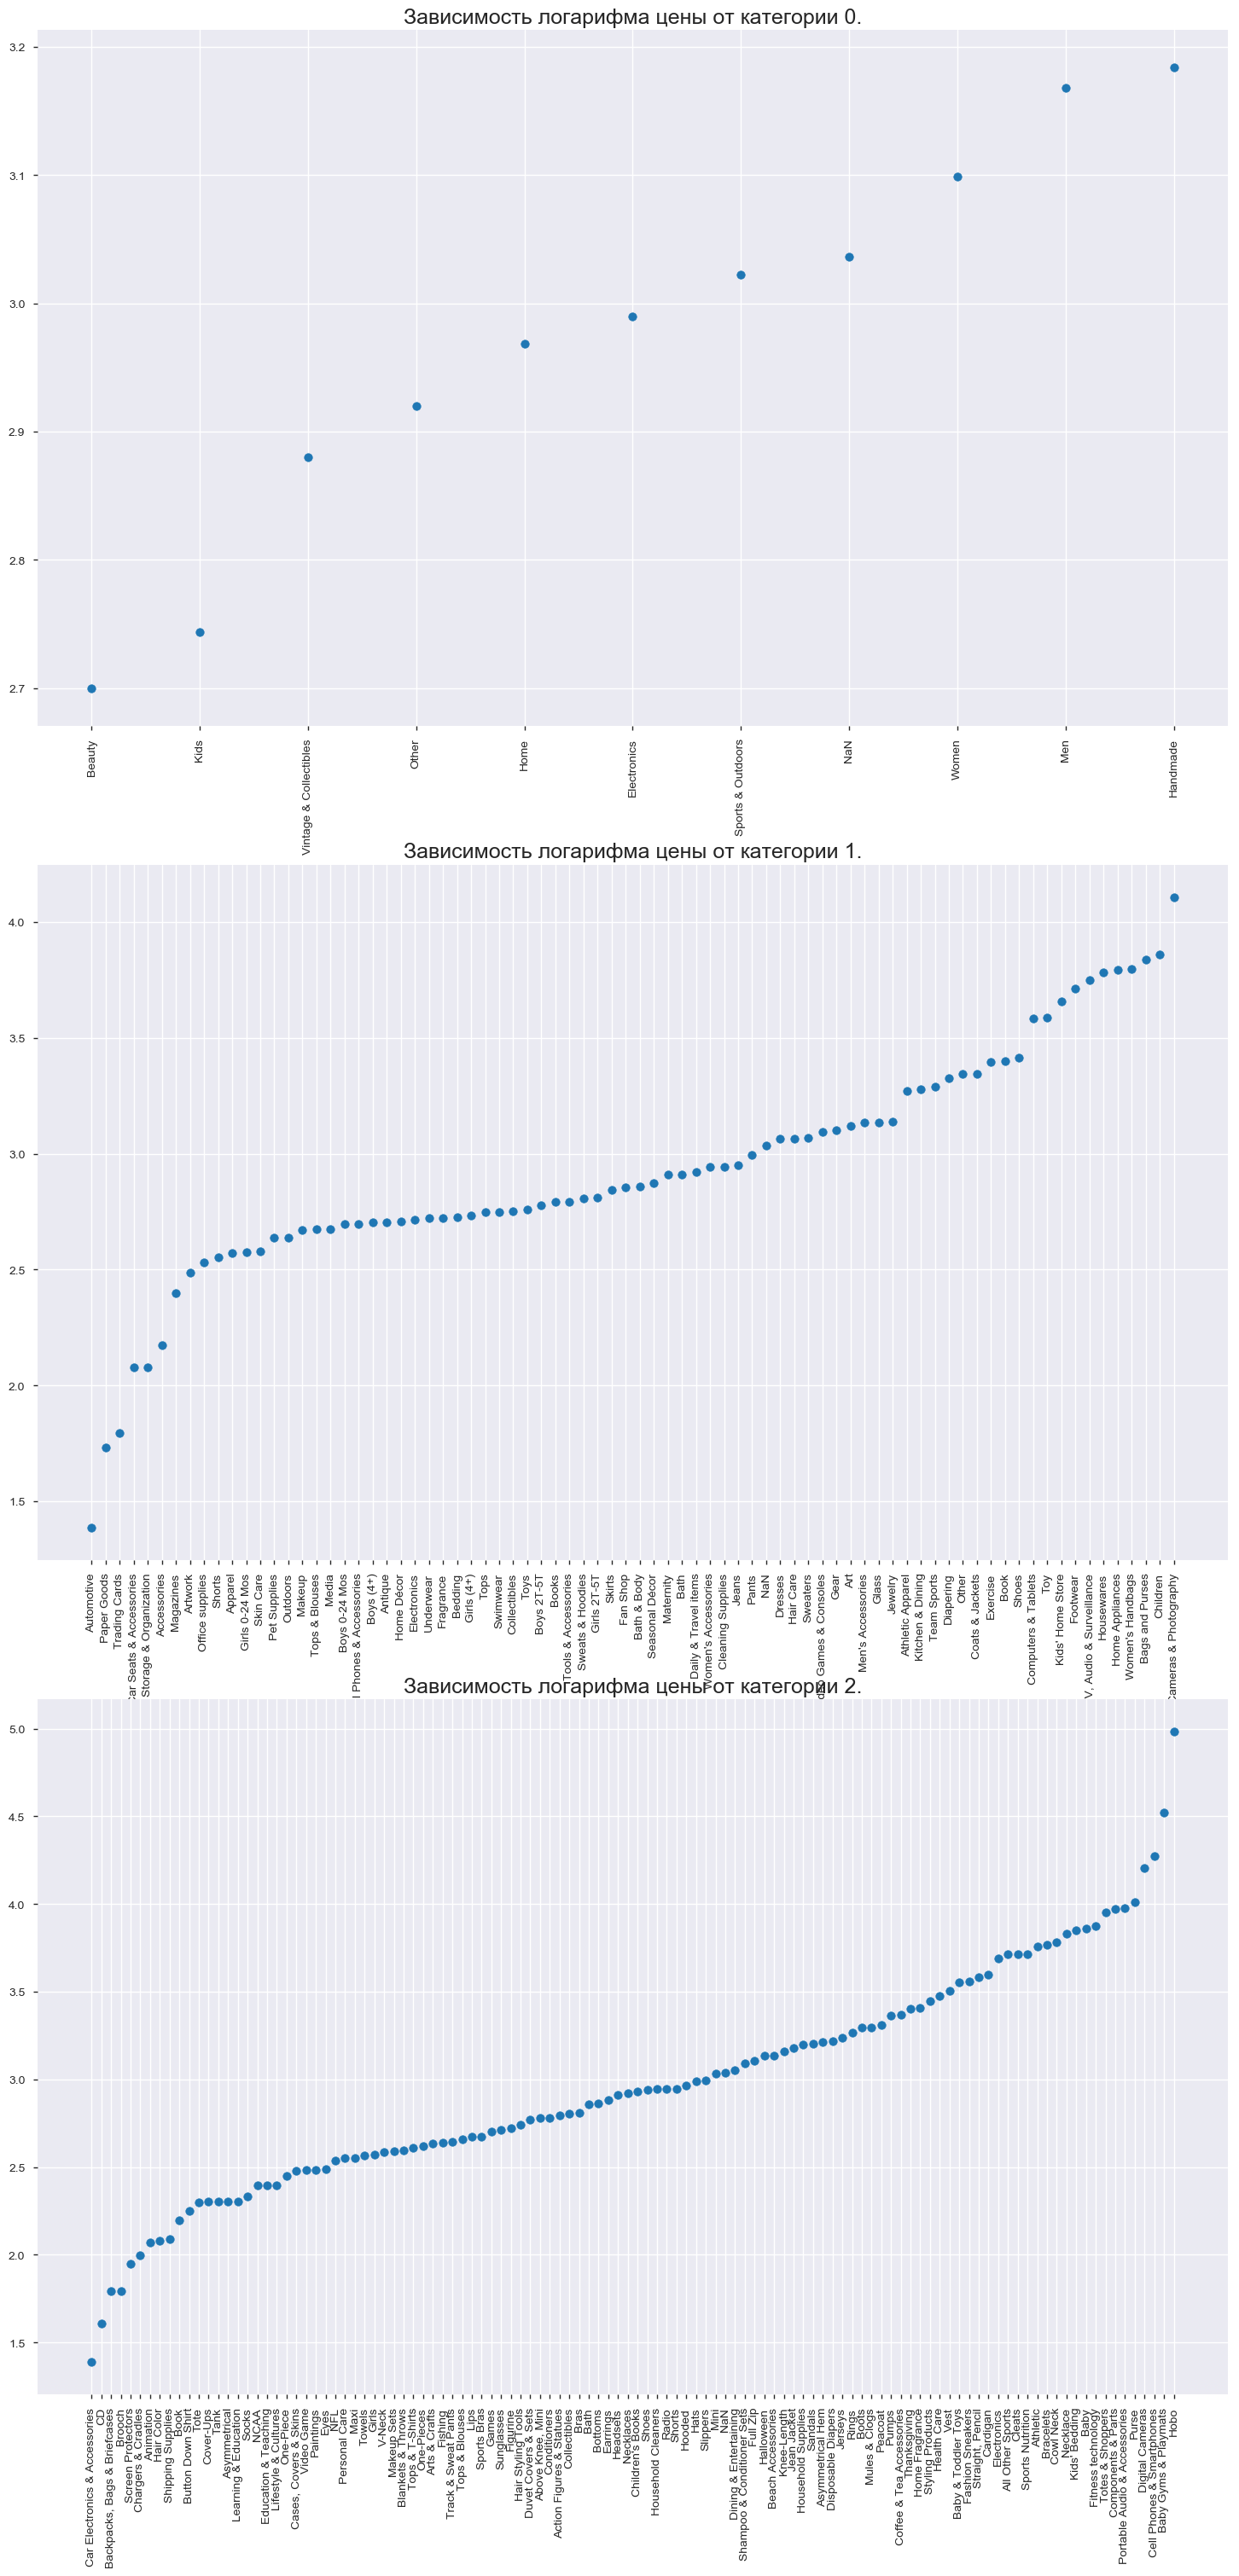

In [55]:
cat0_pl = df_sample.groupby("category_0").mean()["price_log"].sort_values()
cat1_pl = df_sample.groupby("category_1").mean()["price_log"].sort_values()
cat2_pl = df_sample.groupby("category_2").mean()["price_log"].sort_values()

fig, ax = plt.subplots(3, 1, figsize=(18, 36))

ax[0].scatter(cat0_pl.index, cat0_pl.values)
ax[0].set_title("Зависимость логарифма цены от категории 0.", fontsize=18)
ax[0].set_xticklabels(cat0_pl.index, rotation=90)

ax[1].scatter(cat1_pl.index, cat1_pl.values)
ax[1].set_title("Зависимость логарифма цены от категории 1.", fontsize=18)
ax[1].set_xticklabels(cat1_pl.index, rotation=90)

ax[2].scatter(cat2_pl.index[::2], cat2_pl.values[::2])
ax[2].set_title("Зависимость логарифма цены от категории 2.", fontsize=18)
ax[2].set_xticklabels(cat2_pl.index[::2], rotation=90)

plt.show()

In [56]:
df_sample.corr()

,train_id,item_condition_id,price,shipping,price_log,brand_name_le,category_0_le,category_1_le,category_2_le
train_id,1.00,0.02,-0.04,0.03,-0.02,0.03,-0.01,0.05,0.02
item_condition_id,0.02,1.00,-0.01,-0.18,-0.02,0.05,0.20,0.11,0.09
price,-0.04,-0.01,1.00,-0.09,0.74,0.58,0.13,0.30,0.44
shipping,0.03,-0.18,-0.09,1.00,-0.24,-0.18,-0.17,-0.19,-0.20
price_log,-0.02,-0.02,0.74,-0.24,1.00,0.66,0.22,0.47,0.64
brand_name_le,0.03,0.05,0.58,-0.18,0.66,1.00,0.23,0.37,0.46
category_0_le,-0.01,0.20,0.13,-0.17,0.22,0.23,1.00,0.49,0.33
category_1_le,0.05,0.11,0.30,-0.19,0.47,0.37,0.49,1.00,0.70
category_2_le,0.02,0.09,0.44,-0.20,0.64,0.46,0.33,0.70,1.00


Проверка информативности признака, отображающего длину описания товара. Расчет на то, что продавец, стремясь продать товар дороже, будет более тщательно его рекламировать. Не удалось увидеть зависимости цены с таким признаком, он был исключен.

In [57]:
def process_description(data):
    data["item_description"].fillna("", inplace=True)
    data["description_length"] = data["item_description"].apply(lambda x: len(x) if x != "No description yet" else 0)

In [58]:
process_description(df_sample)
df_sample.corr()

,train_id,item_condition_id,price,shipping,price_log,brand_name_le,category_0_le,category_1_le,category_2_le,description_length
train_id,1.00,0.02,-0.04,0.03,-0.02,0.03,-0.01,0.05,0.02,0.01
item_condition_id,0.02,1.00,-0.01,-0.18,-0.02,0.05,0.20,0.11,0.09,-0.12
price,-0.04,-0.01,1.00,-0.09,0.74,0.58,0.13,0.30,0.44,0.06
shipping,0.03,-0.18,-0.09,1.00,-0.24,-0.18,-0.17,-0.19,-0.20,0.07
price_log,-0.02,-0.02,0.74,-0.24,1.00,0.66,0.22,0.47,0.64,0.04
brand_name_le,0.03,0.05,0.58,-0.18,0.66,1.00,0.23,0.37,0.46,0.01
category_0_le,-0.01,0.20,0.13,-0.17,0.22,0.23,1.00,0.49,0.33,-0.07
category_1_le,0.05,0.11,0.30,-0.19,0.47,0.37,0.49,1.00,0.70,0.00
category_2_le,0.02,0.09,0.44,-0.20,0.64,0.46,0.33,0.70,1.00,0.03
description_length,0.01,-0.12,0.06,0.07,0.04,0.01,-0.07,0.00,0.03,1.00


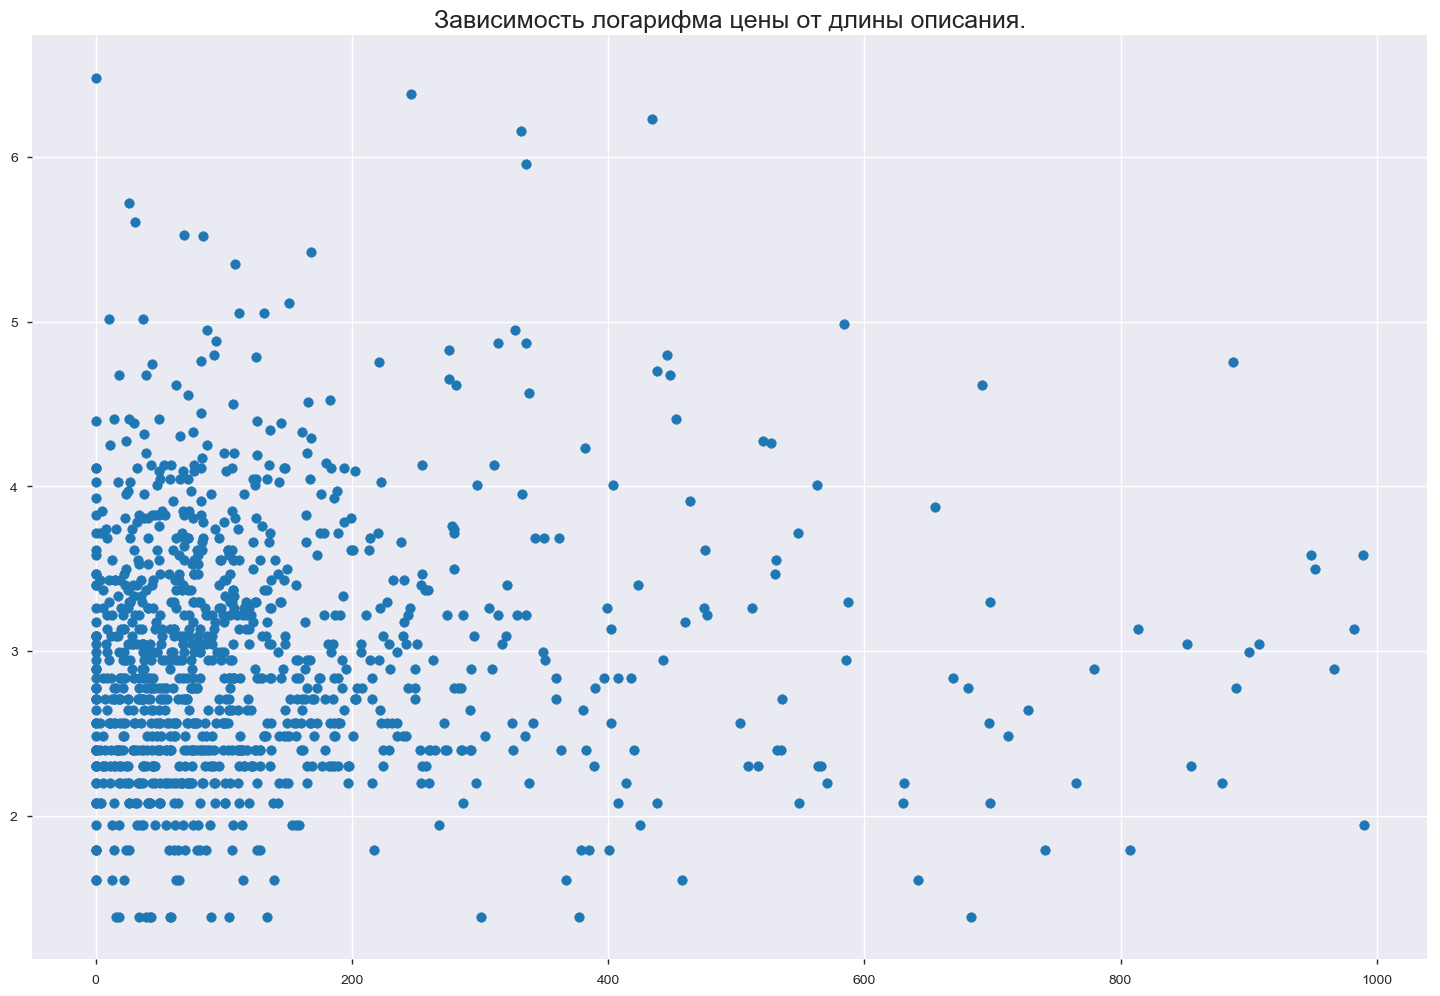

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(18, 12))

ax.scatter(df_sample["description_length"], df_sample["price_log"])
ax.set_title("Зависимость логарифма цены от длины описания.", fontsize=18)

plt.show()

In [60]:
X_sample = df_sample[["item_condition_id", "shipping", "brand_name_le", "description_length"]].values
X_sample_dl = df_sample[["item_condition_id", "shipping", "brand_name_le"]].values

In [61]:
reg_dl = RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0, 1000.0], cv=5)
reg = RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0, 1000.0], cv=5)
reg_dl.fit(X_sample_dl, y_sample)
reg.fit(X_sample, y_sample)

print("R^2 регрессии с учетом description_length: {0}, \nR^2 без этого признака: {1}".format(reg.score(X_sample, y_sample),
                                                                                            reg_dl.score(X_sample_dl, y_sample)))
RMSLE_dl = np.sqrt(mean_squared_log_error(y_true=np.exp(y_sample), y_pred=np.exp(reg_dl.predict(X_sample_dl))))
RMSLE = np.sqrt(mean_squared_log_error(y_true=np.exp(y_sample), y_pred=np.exp(reg.predict(X_sample))))
print("RMSLE регрессии с учетом description_length: {0}, \nRMSLE без этого признака: {1}".format(RMSLE, RMSLE_dl))

R^2 регрессии с учетом description_length: 0.461513973027001, 
R^2 без этого признака: 0.4603948304494611
RMSLE регрессии с учетом description_length: 0.5343379059485747, 
RMSLE без этого признака: 0.5349655829330702


Применение ridge-регрессии с кросс-валидацией, при добавлении новых признаков закодированных подкатегорий, показало рост $R^2$ и снижение ошибки модели. Метрикой качества использовалась RMSLE, что является требованием этого соревнования.

In [62]:
def get_non_text_features(data):
    return data[["item_condition_id", "shipping", "brand_name_le",
               "category_0_le", "category_1_le", "category_2_le"]].values

In [63]:
def apply_RidgeCV(X, y):
    reg = RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0, 1000.0], cv=5)
    reg.fit(X, y)
    print("R^2 = " + str(reg.score(X, y)))
    print(np.sqrt(mean_squared_log_error(y_true=np.exp(y), y_pred=np.exp(reg.predict(X)))))

In [64]:
def apply_Ridge(X, y, alpha=1.0):
    reg = Ridge(alpha=alpha)
    reg.fit(X, y)
    print("R^2 = " + str(reg.score(X, y)))
    print(np.sqrt(mean_squared_log_error(y_true=np.exp(y), y_pred=np.exp(reg.predict(X)))))

In [65]:
X_non_text_features = get_non_text_features(df_sample)
apply_RidgeCV(X_non_text_features, y_sample)

R^2 = 0.5946961529715824
0.46393580126217254


Масштабирование этих признаков не внесло видимого вклада в улучшение результата.

In [66]:
mmscaler = MinMaxScaler()
sdscaler = StandardScaler()

y_sample_scaled = mmscaler.fit_transform(y_sample.values.reshape(-1, 1))
X_sample_scaled = sdscaler.fit_transform(X_non_text_features)
reg = RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0, 1000.0], cv=5)
reg.fit(X_sample_scaled, y_sample_scaled)
print("R^2 = " + str(reg.score(X_sample_scaled, y_sample_scaled)))
print(np.sqrt(mean_squared_log_error(y_true=np.exp(mmscaler.inverse_transform(y_sample_scaled)),
                                     y_pred=np.exp(mmscaler.inverse_transform(reg.predict(X_sample_scaled))))))

R^2 = 0.5952487308773691
0.463619924316609


Получение новых признаков путем векторизации текстовых полей названия и описания товара. При применении к описанию товара, CountVectorizer показал лучшие результаты на выборке, чем TfidfVectorizer.

In [67]:
couvec = CountVectorizer()
X_name = couvec.fit_transform(df_sample["name"]).toarray()
X_non_text_name = np.c_[X_non_text_features, X_name]
apply_RidgeCV(X_non_text_name, y_sample)

R^2 = 0.7555540665706213
0.3605131996830254


In [68]:
tfidf_descr = TfidfVectorizer(stop_words="english", max_features=5000)
X_descr = tfidf_descr.fit_transform(df_sample["item_description"]).toarray()
X = np.c_[X_non_text_features, X_name, X_descr]
number_non_text, number_name, number_descr = X_non_text_features.shape[1], X_name.shape[1], X_descr.shape[1]
apply_RidgeCV(X, y_sample)

R^2 = 0.7867814699172254
0.33671658307364244


In [69]:
couvec_descr = CountVectorizer(stop_words="english")
X_descr = couvec_descr.fit_transform(df_sample["item_description"]).toarray()
X = np.c_[X_non_text_features, X_name, X_descr]
number_non_text, number_name, number_descr = X_non_text_features.shape[1], X_name.shape[1], X_descr.shape[1]
apply_RidgeCV(X, y_sample)

R^2 = 0.8810247688956494
0.25160284614700335


Проверка вариантов построения ансамблей. Для блендинга обучающая выборка разбита на подмножества для тренировки базовых алгоритмов и метаалгоритма. Испытывались несколько регрессионных моделей. Отклики базовых алгоритмов на тренировочном множестве обучали метаалгоритм, затем использовались на тестовом для итогового предсказания.

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y_sample, random_state=42)
X_base, X_meta, y_base, y_meta = train_test_split(X_train, y_train, random_state=42)

In [71]:
reg_ard = ARDRegression()
reg_ard.fit(X_base, y_base)
print(np.sqrt(mean_squared_log_error(y_true=np.exp(y_test), y_pred=np.exp(reg_ard.predict(X_test)))))
x_meta_ard = reg_ard.predict(X_meta)
x_test_ard = reg_ard.predict(X_test)

0.5523517702201829


In [72]:
reg_br = BayesianRidge()
reg_br.fit(X_base, y_base)
print(np.sqrt(mean_squared_log_error(y_true=np.exp(y_test), y_pred=np.exp(reg_br.predict(X_test)))))
x_meta_br = reg_br.predict(X_meta)
x_test_br = reg_br.predict(X_test)

0.446149879287331


In [73]:
reg_hu = HuberRegressor()
reg_hu.fit(X_base, y_base)
print(np.sqrt(mean_squared_log_error(y_true=np.exp(y_test), y_pred=np.exp(reg_hu.predict(X_test)))))
x_meta_hu = reg_hu.predict(X_meta)
x_test_hu = reg_hu.predict(X_test)

0.46895717251641406


In [74]:
reg_lasso = LassoCV(alphas=[0.1, 1.0, 10.0, 100.0, 1000.0], cv=5)
reg_lasso.fit(X_base, y_base)
print(np.sqrt(mean_squared_log_error(y_true=np.exp(y_test), y_pred=np.exp(reg_lasso.predict(X_test)))))
x_meta_la = reg_lasso.predict(X_meta)
x_test_la = reg_lasso.predict(X_test)

0.5026517489043143


In [75]:
reg_ts = TheilSenRegressor()
reg_ts.fit(X_base, y_base)
print(np.sqrt(mean_squared_log_error(y_true=np.exp(y_test), y_pred=np.exp(reg_ts.predict(X_test)))))
x_meta_ts = reg_ts.predict(X_meta)
x_test_ts = reg_ts.predict(X_test)

0.5289089342322395


In [76]:
X_meta_meta = np.c_[x_meta_ard, x_meta_la, x_meta_br, x_meta_hu, x_meta_ts]
X_test_meta = np.c_[x_test_ard, x_test_la, x_test_br, x_test_hu, x_test_ts]

In [77]:
reg_meta = RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0, 1000.0], cv=5)
reg_meta.fit(X_meta_meta, y_meta)
print("RMSLE на обучающем множестве: " + str(np.sqrt(mean_squared_log_error(y_true=np.exp(y_meta), y_pred=np.exp(reg_meta.predict(X_meta_meta))))))
print("RMSLE на тестовом множестве: " + str(np.sqrt(mean_squared_log_error(y_true=np.exp(y_test), y_pred=np.exp(reg_meta.predict(X_test_meta))))))

RMSLE на обучающем множестве: 0.527635277309067
RMSLE на тестовом множестве: 0.44624369547454307


Испытание усреднения результата применения разных моделей на нетекстовых и текстовых признаках. На нетекстовых использовался random forest, на разреженных матрицах векторизованных текстовых признаков применялась регрессионная модель.

In [78]:
X_non_text_features_train = X_train[:, :number_non_text]
X_non_text_features_test = X_test[:, :number_non_text]
reg_rf = RandomForestRegressor()
reg_rf.fit(X_non_text_features_train, y_train)
print(np.sqrt(mean_squared_log_error(y_true=np.exp(y_train), y_pred=np.exp(reg_rf.predict(X_non_text_features_train)))))
print(np.sqrt(mean_squared_log_error(y_true=np.exp(y_test), y_pred=np.exp(reg_rf.predict(X_non_text_features_test)))))

0.30301384065001596
0.484319599410903


In [79]:
X_name_train = X_train[:, number_non_text : number_non_text + number_name]
X_name_test = X_test[:, number_non_text : number_non_text + number_name]
reg_ridge_1 = RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0, 1000.0], cv=5)
reg_ridge_1.fit(X_name_train, y_train)
print(np.sqrt(mean_squared_log_error(y_true=np.exp(y_train), y_pred=np.exp(reg_ridge_1.predict(X_name_train)))))
print(np.sqrt(mean_squared_log_error(y_true=np.exp(y_test), y_pred=np.exp(reg_ridge_1.predict(X_name_test)))))

0.5213963016925519
0.6503559279780968


In [80]:
X_descr_train = X_train[:, number_non_text + number_name : number_non_text + number_name + number_descr]
X_descr_test = X_test[:, number_non_text + number_name : number_non_text + number_name + number_descr]
reg_ridge_2 = RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0, 1000.0], cv=5)
reg_ridge_2.fit(X_descr_train, y_train)
print(np.sqrt(mean_squared_log_error(y_true=np.exp(y_train), y_pred=np.exp(reg_ridge_2.predict(X_descr_train)))))
print(np.sqrt(mean_squared_log_error(y_true=np.exp(y_test), y_pred=np.exp(reg_ridge_2.predict(X_descr_test)))))

0.6316846031326494
0.6583983717747063


In [81]:
y_bag = (reg_rf.predict(X_non_text_features_test) + reg_ridge_1.predict(X_name_test) + reg_ridge_2.predict(X_descr_test))/3
print(np.sqrt(mean_squared_log_error(y_true=np.exp(y_test), y_pred=np.exp(y_bag))))

0.535096733776608


Проверка результатов алгоритмов бустинга из sklearn.

In [82]:
reg_xgb = xgb.XGBRegressor()
reg_xgb.fit(X, y_sample)
print(np.sqrt(mean_squared_log_error(y_true=np.exp(y_sample), y_pred=np.exp(reg_xgb.predict(X)))))

0.35016890102848736


In [83]:
reg_lgb= lgb.LGBMRegressor()
reg_lgb.fit(X, y_sample.ravel())
print(np.sqrt(mean_squared_log_error(y_true=np.exp(y_sample), y_pred=np.exp(reg_lgb.predict(X)))))

0.26098753573515227


In [84]:
param_rf = {"max_depth": [3,6,9,12,None]}
reg_rf= RandomForestRegressor()
grd = GridSearchCV(reg_rf, param_grid=param_rf, cv=5, scoring="neg_mean_squared_error", n_jobs=7, verbose=2)
grd.fit(X, y_sample)
print(np.sqrt(mean_squared_log_error(y_true=np.exp(y_sample), y_pred=np.exp(grd.predict(X)))))
print(grd.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=7)]: Done  25 out of  25 | elapsed:   13.8s remaining:    0.0s
[Parallel(n_jobs=7)]: Done  25 out of  25 | elapsed:   13.8s finished


0.29638394905872734
{'max_depth': 12}


Объединение двух моделей с лучшими результатами (Ridge-регрессия и LGBM).

In [85]:
reg = RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0, 1000.0], cv=5)
reg.fit(X, y_sample)
y_a = (reg.predict(X) + reg_lgb.predict(X)) / 2
print(np.sqrt(mean_squared_log_error(y_true=np.exp(y_sample), y_pred=np.exp(y_a))))

0.24361749139782243


Проверка моделей на полной тренировочной выборке. Здесь при преобразовании описания товара TfidfVectorizer позволил достичь лучшего результата, чем CountVectorizer.

In [86]:
process_category(df)
df["item_description"].fillna("NaN", inplace=True)
df_test["item_description"].fillna("NaN", inplace=True)

y = df["price_log"].values
X_non_text_features = get_non_text_features(df)
non_text_features_number = X_non_text_features.shape[1]

In [87]:
name_full = pd.concat([df["name"], df_test["name"]], 0)
descr_full = pd.concat([df["item_description"], df_test["item_description"]], 0)
train_num = df.shape[0]

In [88]:
couvec_name = CountVectorizer(min_df=10)
name = couvec_name.fit_transform(name_full)

In [89]:
#couvec_descr = CountVectorizer(stop_words="english", max_df=50000)
#descr = couvec_descr.fit_transform(descr_full)

In [90]:
tfidf_descr = TfidfVectorizer(stop_words="english", max_features=50000)
descr = tfidf_descr.fit_transform(descr_full)

In [91]:
X = scipy.sparse.hstack((X_non_text_features, name[:train_num], descr[:train_num])).tocsr()

In [92]:
reg = RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0, 1000.0], cv=5)
reg.fit(X, y)
print(np.sqrt(mean_squared_log_error(y_true=np.exp(y), y_pred=np.exp(reg.predict(X)))))
print("alpha = {}".format(reg.alpha_))

0.4427768926519591
alpha = 10.0


Подбор параметров для LGBM.

In [65]:
reg_lgb= lgb.LGBMRegressor()
reg_lgb.fit(X, y)
print(np.sqrt(mean_squared_log_error(y_true=np.exp(y), y_pred=np.exp(reg_lgb.predict(X)))))

0.48822676138154875


Перебирались, последовательно, параметры learning_rate (0.5, 0.75, 1), num_boosts_round (1000, 2000, 3000), max_depth (2, 3, 4) и num_leaves (50, 100, 150).  

In [22]:
lgb_param_grid = {"learning_rate": [0.75],
                  "num_boost_round": [3000],
                 "max_depth": [4],
                 "num_leaves": [50, 100, 150]}

In [23]:
reg_lgb3 = lgb.LGBMRegressor(application="regression", metric="RMSE")
grd_search = GridSearchCV(reg_lgb3, param_grid=lgb_param_grid, cv=3, scoring="neg_mean_squared_error", n_jobs=4, verbose=3)

In [24]:
grd_search.fit(X, y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=4)]: Done   6 out of   9 | elapsed: 42.9min remaining: 21.5min
[Parallel(n_jobs=4)]: Done   9 out of   9 | elapsed: 52.7min finished
D:\Programs\Anaconda3\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


GridSearchCV(cv=3, error_score='raise',
       estimator=LGBMRegressor(application='regression', boosting_type='gbdt',
       class_weight=None, colsample_bytree=1.0, importance_type='split',
       learning_rate=0.1, max_depth=-1, metric='RMSE',
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'learning_rate': [0.75], 'num_boost_round': [3000], 'max_depth': [4], 'num_leaves': [50, 100, 150]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=3)

In [25]:
grd_search.best_params_

{'learning_rate': 0.75,
 'max_depth': 4,
 'num_boost_round': 3000,
 'num_leaves': 50}

In [66]:
d_train = lgb.Dataset(X, label=y)
params = {
        'learning_rate': 0.75,
        'application': 'regression',
        'max_depth': 4,
        'num_leaves': 50,        
        'metric': 'RMSE',
    }

reg_lgb4 = lgb.train(params, train_set=d_train, num_boost_round=3000, verbose_eval=100) 
print(np.sqrt(mean_squared_log_error(y_true=np.exp(y), y_pred=np.exp(reg_lgb4.predict(X)))))

0.39523744668682786


LGBM совместно с Ridge.

In [70]:
y_comb = (reg.predict(X) + reg_lgb4.predict(X))/2
print(np.sqrt(mean_squared_log_error(y_true=np.exp(y), y_pred=np.exp(y_comb))))

0.40409920826307916


Для итоговой проверки выбраны две последних модели. Применение Light GBM алгоритма с подобранными параметрами показало результат в kaggle 0.45426, его усреднение с Ridge-регрессией - 0.45099.